In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from custom_classes import NasaDataset, SimpleAE, split_dataset, fix_seeds

import os
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [3]:
train_dataset = NasaDataset('../datasets/clean_train_data.csv')
fix_seeds(37)
train_dataset, test_dataset = split_dataset(train_dataset, test_size=0.1)
fix_seeds(37)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)
# test_dataset = NasaDataset('../datasets/test.csv')

fix_seeds(37)
train_dataset.to(device)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
fix_seeds(37)
test_dataset.to(device)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)
fix_seeds(37)
val_dataset.to(device)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=..., shuffle=...)
print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (16, 8, 4)

model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
optimiser = optim.Adam(model_ae.parameters(),
                       lr=1e-3)

Train: 13723
Validation: 4840
Test: 2068


In [4]:
models_path = '../Models/'
plots_path = '../Plots/history/'

 10/100: train_loss=289.5315317767503, val_loss=278.4456547788484
 20/100: train_loss=280.02385320760624, val_loss=299.5315528436519
 30/100: train_loss=277.00472705957674, val_loss=275.8470454486697
 40/100: train_loss=257.016827301514, val_loss=264.9470826972173
 50/100: train_loss=206.02372790562882, val_loss=199.03853870375187
 60/100: train_loss=40.9868533816053, val_loss=32.6602555126429
 70/100: train_loss=15.98813281760292, val_loss=12.711627813752909
 80/100: train_loss=15.23058760044703, val_loss=14.898630591285627
 90/100: train_loss=15.246988566508286, val_loss=12.841454896690891
100/100: train_loss=14.47962872117888, val_loss=19.93687713267675

test_loss=18.416624069213867


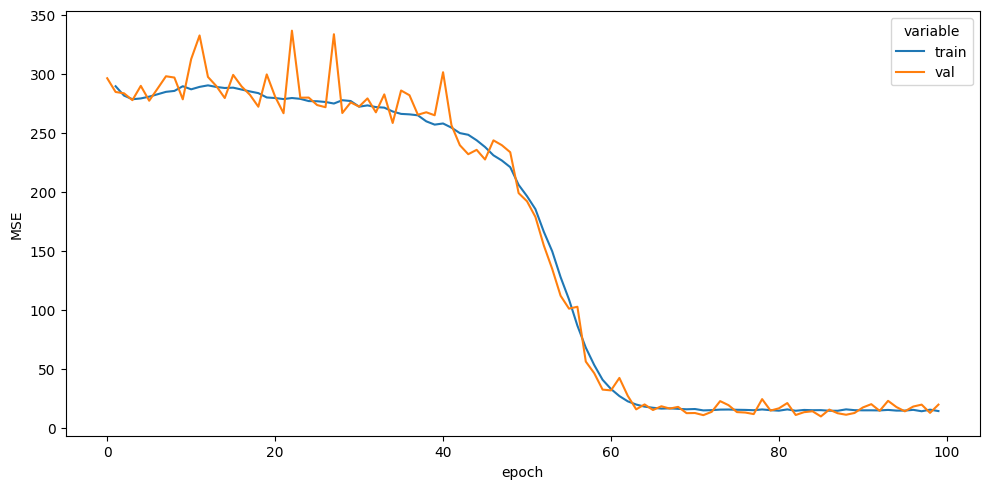

In [5]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss = loss_func(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
    
    with torch.no_grad():
        val_losses = list()
        for dta in val_loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model_ae(sample)
            loss = loss_func(reconstruction, sample)
            val_losses.append(loss.item())
    
    train_loss = mean(train_losses)
    val_loss = mean(val_losses)
    history.append((epoch, train_loss, val_loss))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=}, {val_loss=}')

with torch.no_grad():
    test_losses = list()
    for sample in test_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        loss = loss_func(reconstruction, sample)
        test_losses.append(loss.item())
    test_loss = mean(test_losses)
    print(f'\n{test_loss=}')

name = time.time()
torch.save(model_ae.state_dict(), os.path.join(models_path, f'{name}.pth'))

history_df = pd.DataFrame(history, columns=('epoch', 'train', 'val')).set_index('epoch')
history_df = history_df.melt(ignore_index=False).iloc[1:]
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.lineplot(data=history_df,
             x=history_df.index,
             y='value',
             hue='variable')

ax.set_ylabel('MSE')

plt.tight_layout()
plt.savefig(os.path.join(plots_path, f'{name}.png'))
plt.show()
